In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.svm import SVC
from pathlib import Path
import numpy as np
import seaborn as sns
base_folder = 'results/schaefer400'
atlas_basename = 'schaefer400'
output = Path('results')
atlas_networks = [dir_ for dir_ in output.iterdir() if
                        dir_.is_dir() and atlas_basename in dir_.name]
output = output / atlas_basename
subjects_df = pd.read_csv('clinical_data.csv')
subjects_df = subjects_df.astype({'id': int})
subjects_df = subjects_df.set_index('id')
filename = Path('global_measures.csv')

networks_names = {
      "SalVentAttnLH": "Salience/Ventral Attention (Left Hemisphere)", "SalVentAttn": "Salience/Ventral Attention",
      "DorsAttn": "Dorsal Attention", "Cont": "Frontoparietal", "SomMot": "Somatomotor", "Default": "Default", "Vis": "Visual",
      "Limbic": "Limbic", "Global": "Global"
    }
networks_nce = {
      "SalVentAttnLH": "language", "SalVentAttn": "executive", "DorsAttn": "attention", "SomMot": "executive",
      "Cont": "visuoespatial", "Default": "memory", "Vis": "visuoespatial", "Limbic": "memory", "Global": "attention"
    }

In [2]:
def add_curve(graph_densities, measure, lower_error, upper_error, group, color_index, ax):
    ax.plot(graph_densities, measure, label=group, color=f'C{color_index}')
    ax.plot(graph_densities, lower_error, alpha=0.1, color=f'C{color_index}')
    ax.plot(graph_densities, upper_error, alpha=0.1, color=f'C{color_index}')
    ax.legend()
    ax.fill_between(graph_densities, lower_error, upper_error, alpha=0.2)

    
def add_statistical_significance(p_at_thresholds, ax, significance_levels, eps=1e-4):
    pvalues = p_at_thresholds[p_at_thresholds.columns[0]]
    labels = ['*' * i for i in range(len(significance_levels), 0, -1)]
    significance_levels.insert(0, 0.0)
    significance_levels.append(1.)
    labels.append('ns')
    categorized_pvalues = pd.cut(pvalues, significance_levels, right=False, labels=labels)
    spacing = 0.1
    if len(pvalues) > 1:
        spacing = pvalues.index[1] - pvalues.index[0] + eps

    significance_bar(ax, categorized_pvalues, labels, spacing)
    
    
def significance_bar(ax, categorized_pvalues, labels, spacing):
    line_y = ax.get_ylim()[1]
    for label in labels:
        significant_values = categorized_pvalues[categorized_pvalues == label]
        # Build a list of tuples with the start and end of each significant region
        if len(significant_values) > 0 and label not in 'ns':
            significant_regions = [(significant_values.index[0], significant_values.index[0])]
            for i, threshold in enumerate(significant_values.index):
                if i > 0:
                    if threshold - significant_values.index[i - 1] > spacing:
                        significant_regions.append((threshold, threshold))
                    else:
                        significant_regions[-1] = (significant_regions[-1][0], threshold)
            
            for region in significant_regions:
                ax.text(np.mean(region), line_y * 0.975, label, ha='center', va='bottom', color='k',
                        fontweight='bold', alpha=0.9)
                ax.plot(region, [line_y * 0.98, line_y * 0.98], linewidth=0.8, color='k', alpha=0.7, marker='.', ms=3)

def get_network_name(atlas_basename, network):
    return network.lstrip(f'{atlas_basename}_') if is_network(network) else 'Global'


def is_network(atlas_name):
    return len(atlas_name.split('_')) > 1
                

In [15]:
def meshgrid(x, y, h=.02, offset=0.07):
    x_min, x_max = x.min() - offset, x.max() + offset
    y_min, y_max = y.min() - offset, y.max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def add_svm_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)


def normalize_values(df, columns):
    df[columns] = df[columns].astype(float)
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df


def get_measure_at_threshold(subjects_df, groups, measure_label, network, network_nce, filename):
    graph_density, nces, values, categories, group_mapping = 0.0, [], [], [], {}
    for j, group in enumerate(groups):
        group_df = subjects_df[subjects_df['group'] == group]
        group_mapping[group] = j
        group_network_measures = pd.read_pickle(network / f'{filename.stem}_{group}.pkl')
        measures_at_threshold = group_network_measures.sort_values(by='threshold').iloc[-1]
        if measure_label not in measures_at_threshold.index:
            continue
        graph_density = measures_at_threshold['threshold']
        nces.extend(group_df[network_nce].values)
        values.extend(measures_at_threshold[measure_label])
        categories.extend([group] * len(group_df))
    df = pd.DataFrame({'nce': nces, 'measure': values, 'group': categories}).dropna()
    df = normalize_values(df, ['nce', 'measure'])
    return graph_density, df, group_mapping


def fit_and_plot_svm(df, cats_mapping, ax):
    df = df.replace({'group': cats_mapping})
    clf_nces, clf = SVC(), SVC()
    features = df[['nce', 'measure']].values
    nces = features[:, 0].reshape(-1, 1)
    categories = df['group'].values
    # Do a LOOCV to get the accuracy
    accuracies_nce, accuracies_features = [], []
    for i in range(len(features)):
        clf_nces.fit(np.delete(nces, i, axis=0), np.delete(categories, i))
        accuracies_nce.append(clf_nces.score(nces[i].reshape(1, -1), categories[i].reshape(1, -1)))
        clf.fit(np.delete(features, i, axis=0), np.delete(categories, i))
        accuracies_features.append(clf.score(features[i].reshape(1, -1), categories[i].reshape(1, -1)))
    nce_mean, nce_std = np.mean(accuracies_nce), np.std(accuracies_nce)
    features_mean, features_std = np.mean(accuracies_features), np.std(accuracies_features)
    print(f'Mean NCE accuracy: {nce_mean} +/- {nce_std}')
    print(f'Mean features accuracy: {features_mean} +/- {features_std}')
    clf.fit(features, categories)
    xx, yy = meshgrid(features[:, 0], features[:, 1])
    add_svm_contours(ax, clf, xx, yy, cmap='coolwarm', alpha=0.1)
    
    return features_mean - nce_mean, np.sqrt(nce_std ** 2 + features_std ** 2)
    


def add_group_to_plot(measures_values, group, color_index, measure_label, ax):
    group_values = measures_values[measures_values['group'] == group]
    densities, auc_value = group_values['threshold'].values, 0.0
    if measure_label in group_values.columns:
        measure_values = group_values[measure_label].values
        lower_error, upper_error = group_values[measure_label] - group_values[f'{measure_label}_ste'], \
                                   group_values[measure_label] + group_values[f'{measure_label}_ste']
        sorted_densities = np.argsort(densities)
        if group == 'covid':
            group = 'long-COVID'
        else:
            group = group.capitalize()
        add_curve(densities, measure_values, lower_error, upper_error, group, color_index, ax)
        if len(densities) > 1:
            auc_value = auc(densities[sorted_densities], measure_values[sorted_densities])
    return auc_value


In [17]:
def plot_nce_to_measure(atlas_basename, networks_dirs, networks_names, subjects_df, measure_label, measure_desc,
                        networks_nce, output, filename):
    ncols, nrows = 2, -(-len(networks_dirs) // 2)
    fig, axes = plt.subplots(figsize=(15, 5 * nrows), nrows=nrows, ncols=ncols)
    gains = {network.name: {} for network in networks_dirs}
    for i, network in enumerate(networks_dirs):
        print(f'Processing {network.name}')
        ax = axes[i // 2, i % 2] if nrows > 1 else axes[i % 2]
        network_basename = get_network_name(atlas_basename, network.name)
        if network_basename not in networks_nce:
            continue
        network_nce = networks_nce[network_basename]
        groups = sorted(subjects_df['group'].unique())
        graph_density, measure_df, group_mapping = get_measure_at_threshold(subjects_df, groups, measure_label, network,
                                                                            network_nce, filename)
        plot_df = measure_df.copy().replace({'group': {'covid': 'long-COVID', 'control': 'Control'}})
        sns.scatterplot(data=plot_df, x='nce', y='measure', hue='group', ax=ax)
        # nce_measure_corr = measure_df.drop(columns=['group']).corr(numeric_only=False).iloc[0, 1]
        # print(f'Correlation between NCE and {measure_label} for {network_basename}: {nce_measure_corr:.4f}')
        if not measure_df.empty:
            gains[network.name] = fit_and_plot_svm(measure_df, group_mapping, ax)
        ax.legend()
        ax.set_title(f'{networks_names[network_basename]}')
        ax.set_ylabel(f'{measure_desc} at t={graph_density:.2f}')
        ax.set_xlabel(f'{network_nce} score')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.suptitle(measure_desc)
    fig.savefig(output / f'NCE_to_{measure_label}.png')
    plt.show()

    return gains

In [19]:
def classify_with_efficiency(atlas_basename, networks_dirs, subjects_df,
                        networks_nce, filename):
    gains = {network.name: {} for network in networks_dirs}
    for network in networks_dirs:
        print(f'Processing {network.name}')
        network_basename = get_network_name(atlas_basename, network.name)
        if network_basename not in networks_nce:
            continue
        network_nce = networks_nce[network_basename]
        groups = sorted(subjects_df['group'].unique())
        measure_df, group_mapping = get_efficiency_at_threshold(subjects_df, groups, network,
                                                                            network_nce, filename)
        if not measure_df.empty:
            gains[network.name] = fit_svm(measure_df, group_mapping)
        

    return gains


def fit_svm(df, cats_mapping):
    df = df.replace({'group': cats_mapping})
    clf_nces, clf = SVC(), SVC()
    features = df[['nce', 'local_eff', 'global_eff']].values
    nces = features[:, 0].reshape(-1, 1)
    categories = df['group'].values
    accuracies_nce, accuracies_features = [], []
    for i in range(len(features)):
        clf_nces.fit(np.delete(nces, i, axis=0), np.delete(categories, i))
        accuracies_nce.append(clf_nces.score(nces[i].reshape(1, -1), categories[i].reshape(1, -1)))
        clf.fit(np.delete(features, i, axis=0), np.delete(categories, i))
        accuracies_features.append(clf.score(features[i].reshape(1, -1), categories[i].reshape(1, -1)))
    nce_mean, nce_std = np.mean(accuracies_nce), np.std(accuracies_nce)
    features_mean, features_std = np.mean(accuracies_features), np.std(accuracies_features)
    print(f'Mean NCE accuracy: {nce_mean} +/- {nce_std}')
    print(f'Mean features accuracy: {features_mean} +/- {features_std}')
    
    return features_mean - nce_mean, np.sqrt(nce_std ** 2 + features_std ** 2)

def get_efficiency_at_threshold(subjects_df, groups, network, network_nce, filename):
    nces, local_eff_values, global_eff_values, categories, group_mapping = [], [], [], [], {}
    for j, group in enumerate(groups):
        group_df = subjects_df[subjects_df['group'] == group]
        group_mapping[group] = j
        group_network_measures = pd.read_pickle(network / f'{filename.stem}_{group}.pkl')
        measures_at_threshold = group_network_measures.sort_values(by='threshold').iloc[-1]
        if 'global_efficiency' not in measures_at_threshold.index or 'avg_local_efficiency' not in measures_at_threshold.index:
            continue
        graph_density = measures_at_threshold['threshold']
        nces.extend(group_df[network_nce].values)
        local_eff_values.extend(measures_at_threshold['avg_local_efficiency'])
        global_eff_values.extend(measures_at_threshold['global_efficiency'])
        categories.extend([group] * len(group_df))
    df = pd.DataFrame({'nce': nces, 'local_eff': local_eff_values, 'global_eff': global_eff_values, 'group': categories}).dropna()
    df = normalize_values(df, ['nce', 'local_eff', 'global_eff'])
    
    return df, group_mapping

In [20]:
classify_with_efficiency(atlas_basename, atlas_networks, subjects_df, networks_nce, filename)

Processing schaefer400_SalVentAttn
Mean NCE accuracy: 0.6867469879518072 +/- 0.4638163025281965
Mean features accuracy: 0.7710843373493976 +/- 0.4201348379316312
Processing schaefer400_Limbic
Mean NCE accuracy: 0.6951219512195121 +/- 0.4603557582482165
Mean features accuracy: 0.7073170731707317 +/- 0.454994100150674
Processing schaefer400_DorsAttn
Mean NCE accuracy: 0.7142857142857143 +/- 0.45175395145262565
Mean features accuracy: 0.75 +/- 0.4330127018922193
Processing schaefer400_SalVentAttnLH
Mean NCE accuracy: 0.691358024691358 +/- 0.46193301071283227
Mean features accuracy: 0.7530864197530864 +/- 0.43121602954501187
Processing schaefer400_Vis
Mean NCE accuracy: 0.6144578313253012 +/- 0.4867231295596182
Mean features accuracy: 0.5180722891566265 +/- 0.49967328562235475
Processing schaefer400
Mean NCE accuracy: 0.7142857142857143 +/- 0.45175395145262565
Mean features accuracy: 0.7619047619047619 +/- 0.42591770999995987
Processing schaefer400_Cont
Mean NCE accuracy: 0.614457831325301

{'schaefer400_SalVentAttn': (0.08433734939759041, 0.6258105500347254),
 'schaefer400_Limbic': (0.012195121951219523, 0.647261195595883),
 'schaefer400_DorsAttn': (0.0357142857142857, 0.625764838140544),
 'schaefer400_SalVentAttnLH': (0.06172839506172845, 0.6319251304725791),
 'schaefer400_Vis': (-0.09638554216867468, 0.6975477024641026),
 'schaefer400': (0.04761904761904756, 0.6208764195431093),
 'schaefer400_Cont': (-0.03614457831325302, 0.6933732322861763),
 'schaefer400_SomMot': (0.02409638554216864, 0.6485912690937238),
 'schaefer400_Default': (0.03658536585365857, 0.6389359462160847)}

Processing schaefer400_SalVentAttn
Mean NCE accuracy: 0.6867469879518072 +/- 0.4638163025281965
Mean features accuracy: 0.7710843373493976 +/- 0.4201348379316312
Processing schaefer400_Limbic
Mean NCE accuracy: 0.6951219512195121 +/- 0.4603557582482165
Mean features accuracy: 0.6707317073170732 +/- 0.46994753336579737
Processing schaefer400_DorsAttn
Mean NCE accuracy: 0.7142857142857143 +/- 0.45175395145262565
Mean features accuracy: 0.7619047619047619 +/- 0.42591770999995987
Processing schaefer400_SalVentAttnLH
Mean NCE accuracy: 0.691358024691358 +/- 0.46193301071283227
Mean features accuracy: 0.7407407407407407 +/- 0.43822813208145306
Processing schaefer400_Vis
Mean NCE accuracy: 0.6144578313253012 +/- 0.4867231295596182
Mean features accuracy: 0.5301204819277109 +/- 0.49909193198091517
Processing schaefer400
Mean NCE accuracy: 0.7142857142857143 +/- 0.45175395145262565
Mean features accuracy: 0.75 +/- 0.4330127018922193
Processing schaefer400_Cont
Mean NCE accuracy: 0.6144578313253

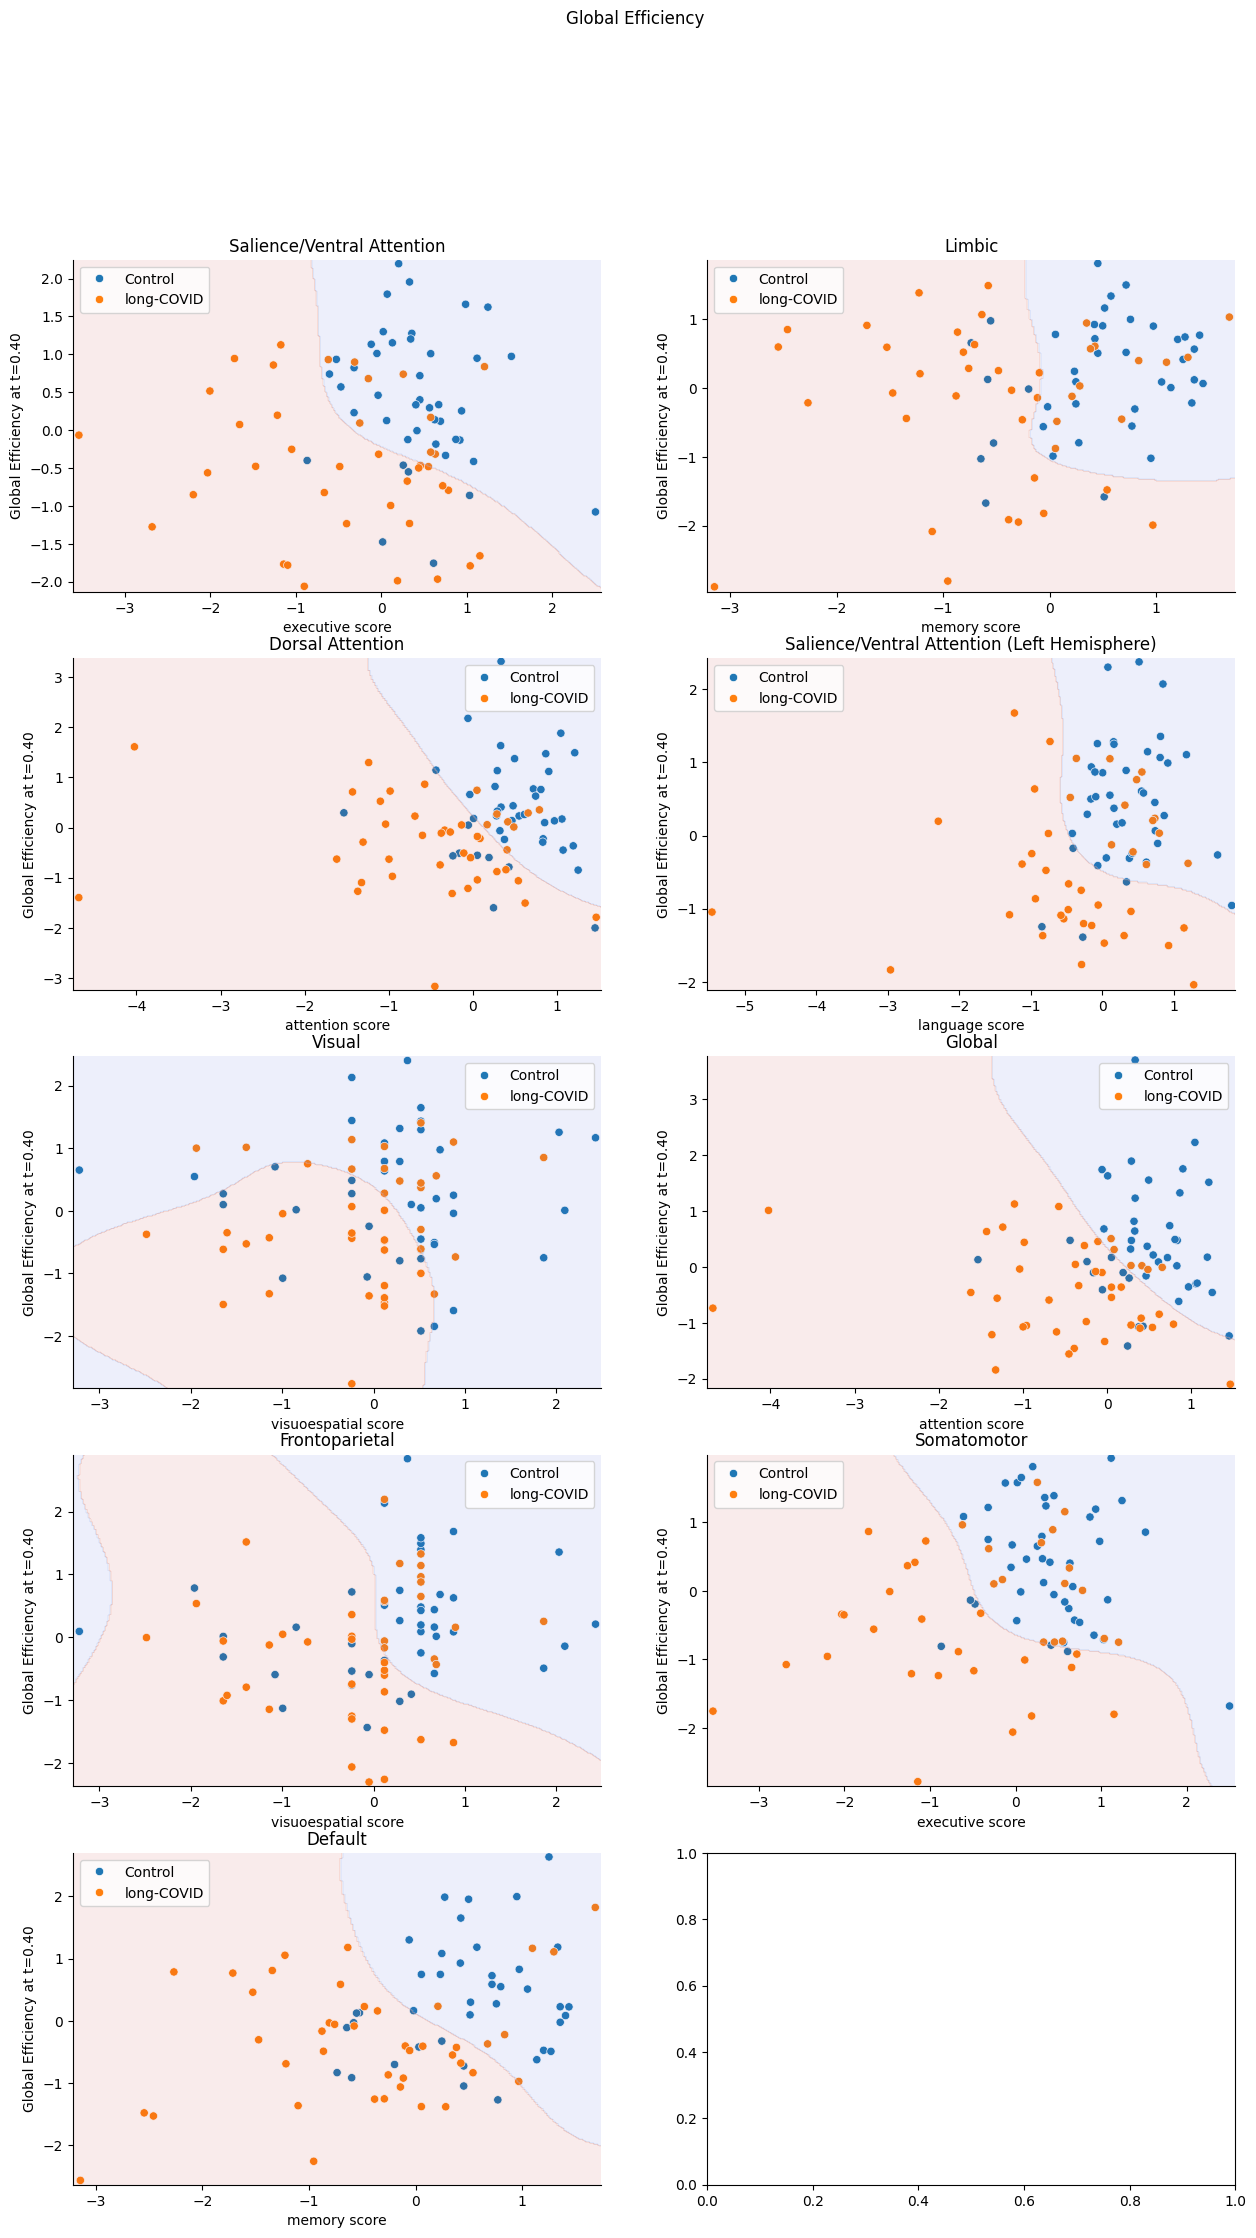

{'schaefer400_SalVentAttn': (0.08433734939759041, 0.6258105500347254),
 'schaefer400_Limbic': (-0.024390243902438935, 0.6578587297200574),
 'schaefer400_DorsAttn': (0.04761904761904756, 0.6208764195431093),
 'schaefer400_SalVentAttnLH': (0.04938271604938271, 0.6367307139865495),
 'schaefer400_Vis': (-0.0843373493975903, 0.6971313803127438),
 'schaefer400': (0.0357142857142857, 0.625764838140544),
 'schaefer400_Cont': (-0.02409638554216864, 0.6919062176077702),
 'schaefer400_SomMot': (0.012048192771084376, 0.6523848853340185),
 'schaefer400_Default': (0.04878048780487809, 0.6343808196897538)}

In [23]:
plot_nce_to_measure(atlas_basename, atlas_networks, networks_names, subjects_df, 'global_efficiency', 'Global Efficiency', networks_nce, output, filename)

Processing schaefer400_SalVentAttn
Mean NCE accuracy: 0.6867469879518072 +/- 0.4638163025281965
Mean features accuracy: 0.7108433734939759 +/- 0.45337078848739226
Processing schaefer400_Limbic
Mean NCE accuracy: 0.6951219512195121 +/- 0.4603557582482165
Mean features accuracy: 0.7073170731707317 +/- 0.454994100150674
Processing schaefer400_DorsAttn
Mean NCE accuracy: 0.7142857142857143 +/- 0.45175395145262565
Mean features accuracy: 0.75 +/- 0.4330127018922193
Processing schaefer400_SalVentAttnLH
Mean NCE accuracy: 0.691358024691358 +/- 0.46193301071283227
Mean features accuracy: 0.7037037037037037 +/- 0.4566232594791834
Processing schaefer400_Vis
Mean NCE accuracy: 0.6144578313253012 +/- 0.4867231295596182
Mean features accuracy: 0.5060240963855421 +/- 0.49996370894569714
Processing schaefer400
Mean NCE accuracy: 0.7142857142857143 +/- 0.45175395145262565
Mean features accuracy: 0.7380952380952381 +/- 0.43967107887189005
Processing schaefer400_Cont
Mean NCE accuracy: 0.614457831325301

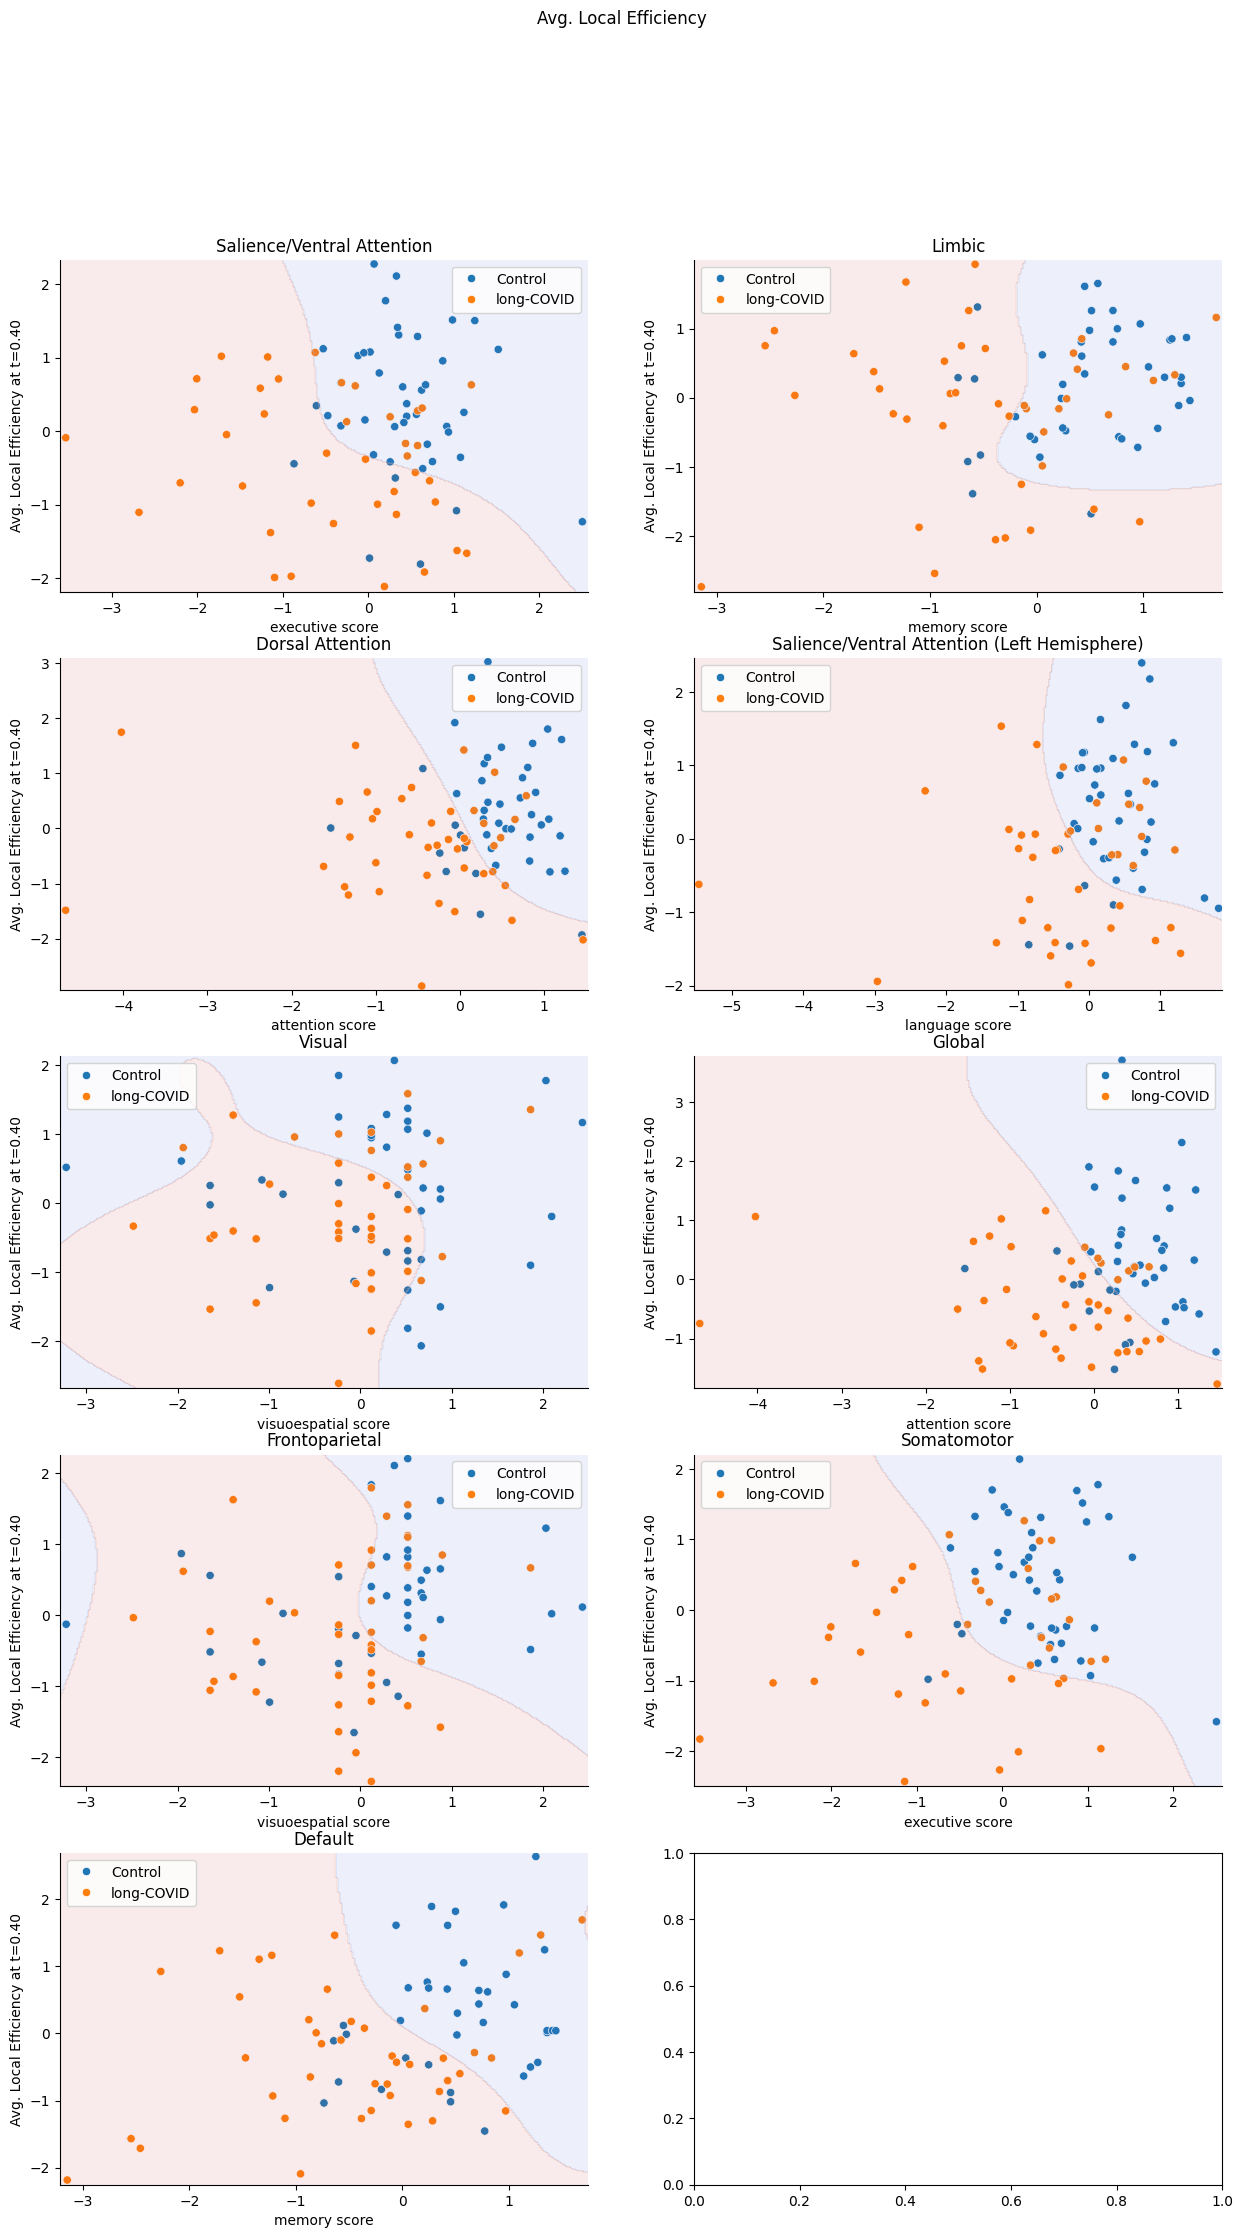

{'schaefer400_SalVentAttn': (0.02409638554216864, 0.6485912690937238),
 'schaefer400_Limbic': (0.012195121951219523, 0.647261195595883),
 'schaefer400_DorsAttn': (0.0357142857142857, 0.625764838140544),
 'schaefer400_SalVentAttnLH': (0.012345679012345734, 0.6495282191588101),
 'schaefer400_Vis': (-0.10843373493975905, 0.6977557703889281),
 'schaefer400': (0.023809523809523836, 0.6303905854701773),
 'schaefer400_Cont': (-0.06024096385542166, 0.695672290759135),
 'schaefer400_SomMot': (0.02409638554216864, 0.6485912690937238),
 'schaefer400_Default': (0.04878048780487809, 0.6343808196897538)}

In [24]:
plot_nce_to_measure(atlas_basename, atlas_networks, networks_names, subjects_df, 'avg_local_efficiency', 'Avg. Local Efficiency', networks_nce, output, filename)

In [8]:
def plot_measure(atlas_basename, networks_dirs, networks_names, measure_label, measure_desc, output, filename):
    ncols, nrows = 2, -(-len(networks_dirs) // 2)
    fig, axes = plt.subplots(figsize=(15, 5 * nrows), nrows=nrows, ncols=ncols)
    aucs = {network.name: {} for network in networks_dirs}
    for i, network in enumerate(networks_dirs):
        measures_values = pd.read_csv(network / filename.name, index_col=0)
        ax = axes[i // 2, i % 2] if nrows > 1 else axes[i % 2]
        groups = sorted(measures_values['group'].unique())
        for color_index, group in enumerate(groups):
            aucs[network.name][group] = add_group_to_plot(measures_values, group, color_index, measure_label, ax)
        if f'{measure_label}_p' in measures_values.columns:
            p_at_thresholds = measures_values[['threshold', f'{measure_label}_p']].drop_duplicates().set_index(
                'threshold')
            add_statistical_significance(p_at_thresholds, ax, significance_levels=[0.001, 0.005, 0.01])
        # Plot a vertical line at each threshold
        for graph_density in measures_values['threshold'].unique():
            ax.axvline(graph_density, color='k', alpha=0.1)
        network_basename = get_network_name(atlas_basename, network.name)
        ax.set_title(f'{networks_names[network_basename]}')
        ax.set_xlabel('Graph density'), ax.set_ylabel(measure_desc)
        ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False)
    fig.suptitle(measure_desc)
    # fig.savefig(output / f'{measure_label}.png')
    plt.show()

    return aucs


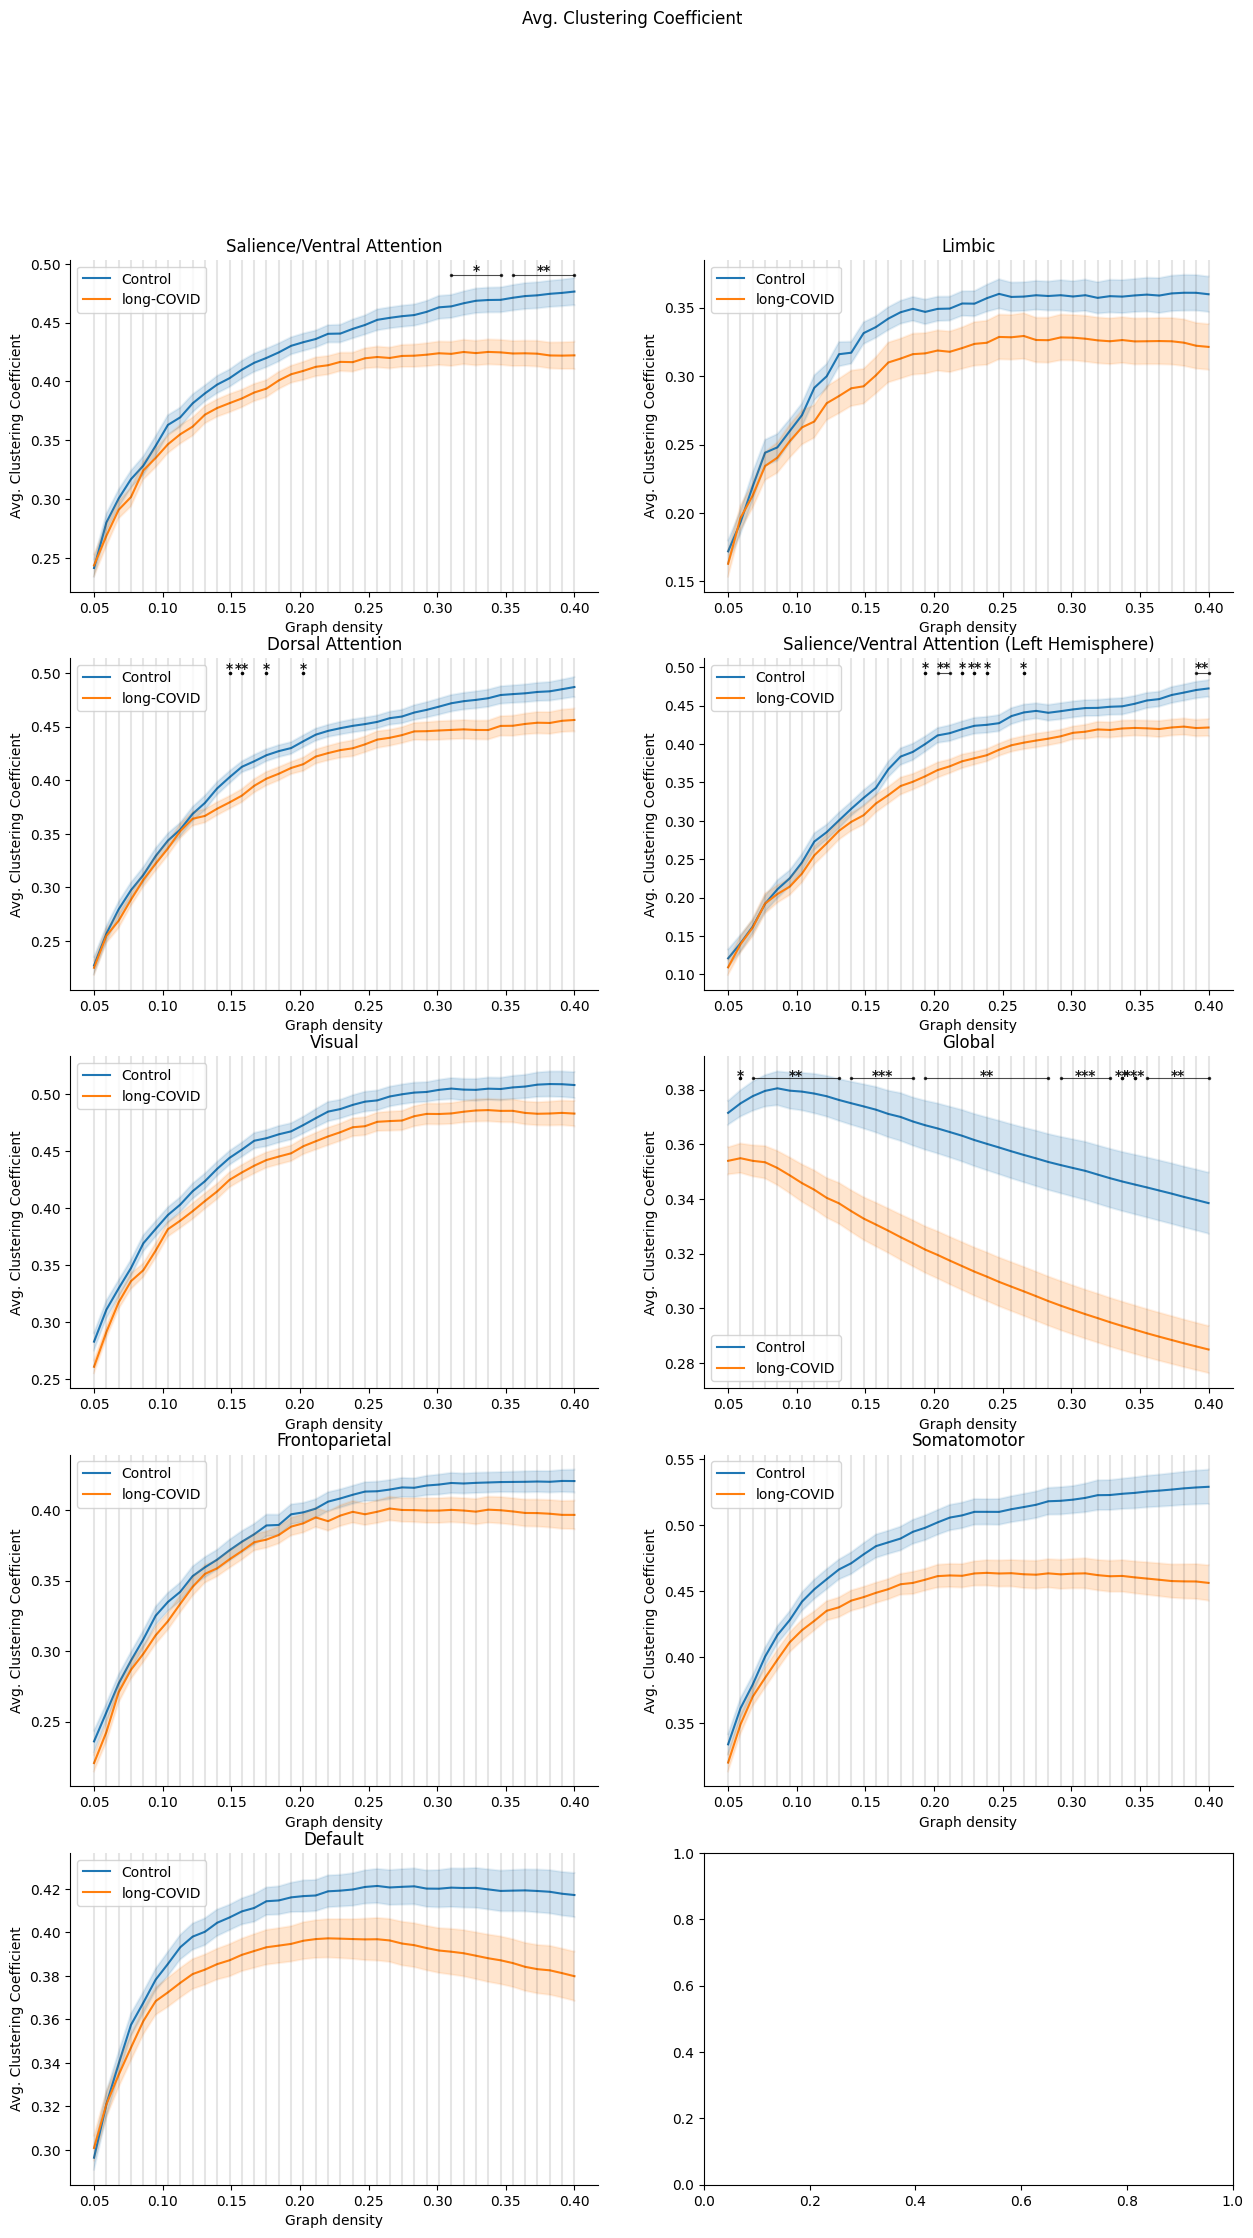

{'schaefer400_SalVentAttn': {'control': 0.1473730589482801,
  'covid': 0.13712477492097325},
 'schaefer400_Limbic': {'control': 0.11523010142523213,
  'covid': 0.10558047257749849},
 'schaefer400_DorsAttn': {'control': 0.14735288005665131,
  'covid': 0.1406481933799932},
 'schaefer400_SalVentAttnLH': {'control': 0.13097733479539886,
  'covid': 0.12071233578656486},
 'schaefer400_Vis': {'control': 0.16082416898705998,
  'covid': 0.15387899955388845},
 'schaefer400': {'control': 0.1265728555222644, 'covid': 0.11105638552428665},
 'schaefer400_Cont': {'control': 0.13441890391470046,
  'covid': 0.129669183316717},
 'schaefer400_SomMot': {'control': 0.17080796211563964,
  'covid': 0.1555549033937047},
 'schaefer400_Default': {'control': 0.1418596133798909,
  'covid': 0.1339962762112907}}

In [10]:
plot_measure(atlas_basename, atlas_networks, networks_names, 'avg_clustering', 'Avg. Clustering Coefficient', output, filename)

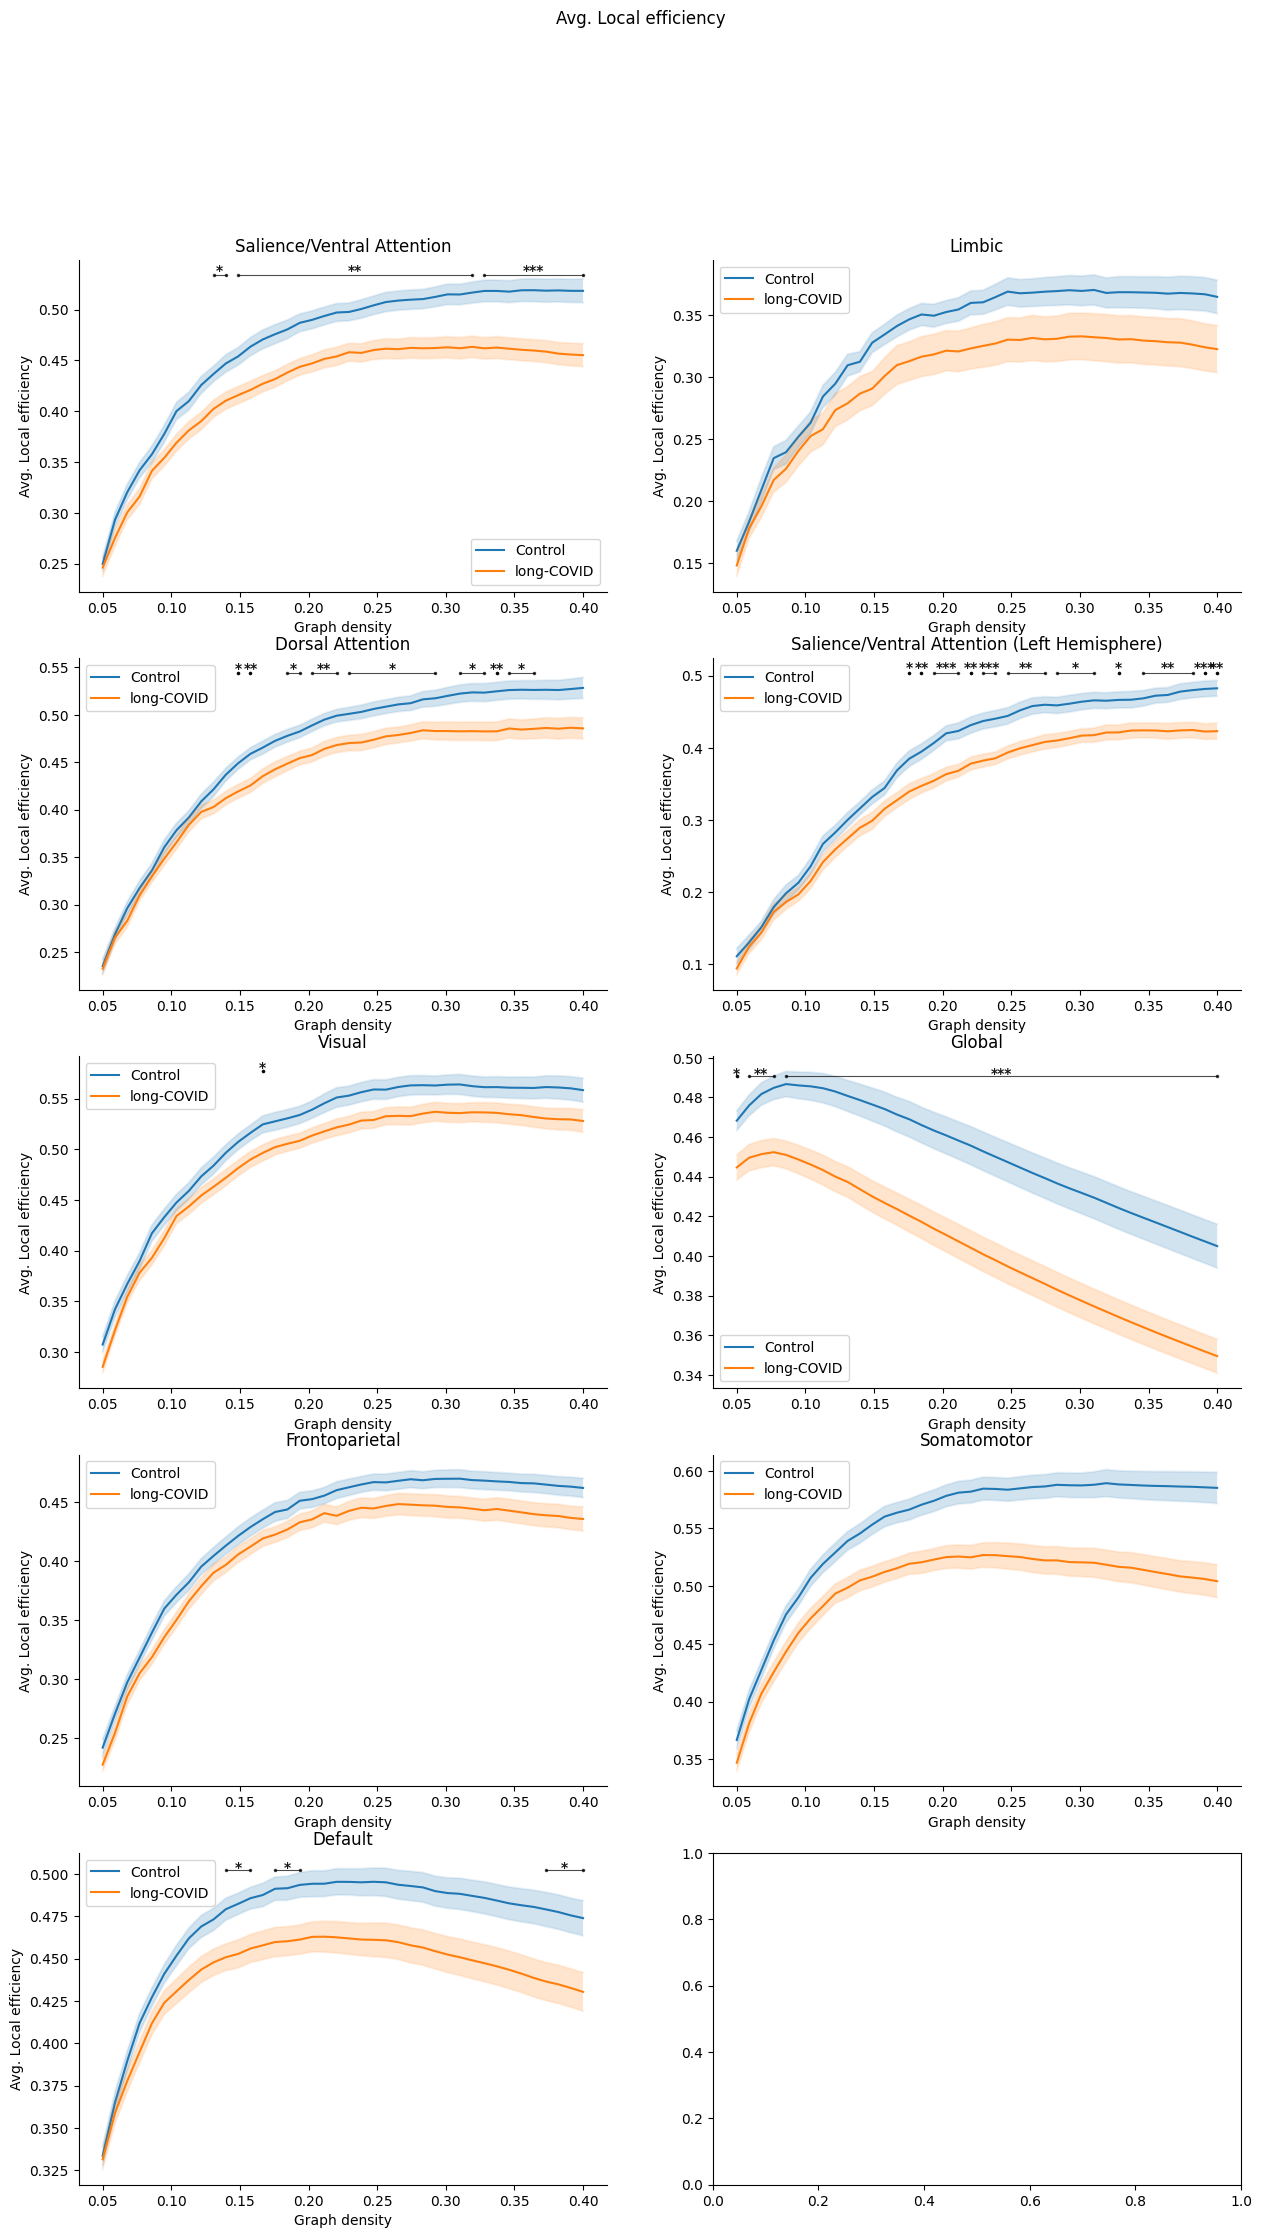

{'schaefer400_SalVentAttn': {'control': 0.16381377539266379,
  'covid': 0.14872304053226681},
 'schaefer400_Limbic': {'control': 0.11617004100036037,
  'covid': 0.1051192402116219},
 'schaefer400_DorsAttn': {'control': 0.16274658854452137,
  'covid': 0.15272146438501535},
 'schaefer400_SalVentAttnLH': {'control': 0.13341174373830467,
  'covid': 0.11929379724515475},
 'schaefer400_Vis': {'control': 0.18104255331677752,
  'covid': 0.1722398918176925},
 'schaefer400': {'control': 0.1581268674615216, 'covid': 0.14120248609798555},
 'schaefer400_Cont': {'control': 0.1505384857609341,
  'covid': 0.1434464580049981},
 'schaefer400_SomMot': {'control': 0.1941875925161068,
  'covid': 0.1751464137182837},
 'schaefer400_Default': {'control': 0.16556286681115515,
  'covid': 0.15471731918947654}}

In [56]:
plot_measure(atlas_basename, atlas_networks, networks_names, 'avg_local_efficiency', 'Avg. Local efficiency', output, filename)